In [45]:
# upload the data file:
from google.colab import files

# connect to google colab:
from google.colab import drive
drive.mount('/content/drive')

# file datapath
filepath =  '/content/drive/MyDrive/DATA ENG 300/HOMEWORK 01/T_F41SCHEDULE_B43.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [46]:
# import libraries:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
import pandas as pd
import re

In [48]:
# load data file:
inventory = pd.read_csv(filepath)
# inventory.info()

<ipython-input-48-3b0d8dbf8f9d>:2: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  inventory = pd.read_csv(filepath)


**QUESTION 01**

In [50]:
# Quick overview of missing values
# inventory[['CARRIER', 'CARRIER_NAME', 'MANUFACTURE_YEAR', 'NUMBER_OF_SEATS', 'CAPACITY_IN_POUNDS', 'AIRLINE_ID']].isnull().sum()

In [8]:
## CARRIER:
# Look at rows where CARRIER is missing
inventory[inventory['CARRIER'].isnull()][['CARRIER', 'CARRIER_NAME', 'UNIQUE_CARRIER']]
# based off of this, North American Airlines carrier seems to be the only carrier with missing values.

# Check what CARRIER values exist for North American Airlines where CARRIER is not null
inventory[(inventory['CARRIER_NAME'] == 'North American Airlines') &
          (inventory['CARRIER'].notnull())]['CARRIER'].unique()

# only unique value is 'NA ' so impute all missing values with 'NA ':
inventory['CARRIER'] = inventory['CARRIER'].fillna('NA ')

# check that no empty values are left
# inventory['CARRIER'].isnull().sum()  # Should be 0

In [51]:
## CARRIER NAME:

# look at rows where CARRIER_NAME is missing
missing_carrier_names = inventory[inventory['CARRIER_NAME'].isnull()][['CARRIER', 'CARRIER_NAME', 'UNIQUE_CARRIER']]
# print("Rows with missing CARRIER_NAME:\n", missing_carrier_names)

# # Check what CARRIER NAME values exist for each carrier where CARRIER is not null
carriers = inventory[inventory['CARRIER_NAME'].isnull()]['CARRIER'].dropna().unique()
# print(carriers)
# the only carriers are 'L4' and 'OH'


## look into 'L4' columns:

L4_names = inventory[inventory['CARRIER'] == 'L4']['CARRIER_NAME'].dropna().unique()
# print(f"\nmode for L4 is: '{L4_names}' and there are '{L4_names.shape}' values ")
# there is only one value so we will impute this value for all rows with 'L4' CARRIER
inventory.loc[
            (inventory['CARRIER'] == 'L4') &
            (inventory['CARRIER_NAME'].isnull()),
            'CARRIER_NAME'
        ] = L4_names[0]


## do the same for 'OH' columns:

OH_names = inventory[inventory['CARRIER'] == 'OH']['CARRIER_NAME'].dropna().unique()
# print(f"\nmode for OH is: '{OH_names}' and there are '{OH_names.shape}' values ")
# there are two options here so pick the mode:
OH_name = inventory[inventory['CARRIER'] == 'OH']['CARRIER_NAME'].dropna().mode()
# print(f"\nmode for OH is: '{OH_name[0]}'")
# fill with the mode:
inventory.loc[
            (inventory['CARRIER'] == 'OH') &
            (inventory['CARRIER_NAME'].isnull()),
            'CARRIER_NAME'
        ] = OH_name[0]

# # # check that no empty values are left
# inventory['CARRIER_NAME'].isnull().sum()  # Should be 0

In [52]:
## MANUFACTURE YEAR:

# look at rows where MANUFACTURE_YEAR is missing
inventory[inventory['MANUFACTURE_YEAR'].isnull()]
# inventory[116645:116655]
# inventory[inventory['CARRIER'] == '9E']

# because there are only 3 rows with missing data, these missing values are unlikely to skew the data so we will not impute these values


,YEAR,CARRIER,CARRIER_NAME,MANUFACTURE_YEAR,UNIQUE_CARRIER_NAME,SERIAL_NUMBER,TAIL_NUMBER,AIRCRAFT_STATUS,OPERATING_STATUS,NUMBER_OF_SEATS,MANUFACTURER,AIRCRAFT_TYPE,MODEL,CAPACITY_IN_POUNDS,ACQUISITION_DATE,AIRLINE_ID,UNIQUE_CARRIER
116651,2022,5Y,Atlas Air Inc.,NaN,Atlas Air Inc.,26259,N664GT,B,Y,0.0,BOEING,8192,B747-400,0.0,1/25/2022 12:00:00 AM,20007.0,5Y
124680,2023,9E,Endeavor Air Inc.,NaN,Endeavor Air Inc.,10134,N655CA,O,Y,69.0,BOMBARDIER,6311,CL-600-2C10,18055.0,NaN,20363.0,9E
124681,2023,9E,Endeavor Air Inc.,NaN,Endeavor Air Inc.,10182,N690CA,O,N,69.0,BOMBARDIER,6311,CL-600-2C10,18055.0,NaN,20363.0,9E


In [53]:
## NUMBER_OF_SEATS

# look at rows where NUMBER_OF_SEATS is missing
inventory[inventory['NUMBER_OF_SEATS'].isnull()]
# all planes with missing number of seats have CARRIER = 'M6' and MODEL = ['767-232SFCARGO', 767-338ERCARGO]

inventory[inventory['CARRIER'] == 'M6']['NUMBER_OF_SEATS'].dropna().unique()
# there are no seat number of seats given for each of the M6 planes, additionally the M6 planes appear to be
# cargo planes (given model names) that likely do not have any seats so we will leave the missing values


array([0.])

In [54]:
## CAPACITY_IN_POUNDS

# look at rows where CAPACITY_IN_POUNDS is missing
inventory[inventory['CAPACITY_IN_POUNDS'].isnull()]

# find the medium capacity for each model that needs to be imputed:
models = inventory[inventory['CAPACITY_IN_POUNDS'].isnull()]['MODEL'].unique()
# print(models)

for model in models:

    median_capacity = inventory[
        (inventory['MODEL'] == model) &
        (inventory['CAPACITY_IN_POUNDS'].notnull())
    ]['CAPACITY_IN_POUNDS'].median()

    # unique_capacities = inventory[
    #     (inventory['MODEL'] == model) &
    #     (inventory['CAPACITY_IN_POUNDS'].notnull())
    # ]['CAPACITY_IN_POUNDS'].unique()

    # print(f"\nmedian value for '{model} is: '{median_capacity}' and the unique capacities are '{unique_capacities}'")
    # the unique capacities are within a reasonable range for each model

    if not pd.isna(median_capacity):
        inventory.loc[
            (inventory['MODEL'] == model) &
            (inventory['CAPACITY_IN_POUNDS'].isnull()),
            'CAPACITY_IN_POUNDS'
        ] = median_capacity

# check that no empty values are left
# inventory['CAPACITY_IN_POUNDS'].isnull().sum()  # Should be 0

In [55]:
## AIRLINE_ID

# look at rows where AIRLINE_ID is missing
inventory[inventory['AIRLINE_ID'].isnull()]

# the AIRLINE_ID corresponds to the carrier, so for each carrier find the unique AIRLINE_ID and impute that value:
carriers = inventory[inventory['AIRLINE_ID'].isnull()]['CARRIER'].unique()

for carrier in carriers:

    # unique_IDs = inventory[
    #     (inventory['CARRIER'] == carrier) &
    #     (inventory['AIRLINE_ID'].notnull())
    # ]['AIRLINE_ID'].unique()

    # print(f"\nUnique IDs are '{unique_IDs}'")
    # only 1 id for L4 and 2 for OH --> look at counts

    # ID_counts = inventory[
    #     (inventory['CARRIER'] == carrier) &
    #     (inventory['AIRLINE_ID'].notnull())
    # ]['AIRLINE_ID'].value_counts()

    # print(f"\nID counts are '{ID_counts}'")
    # # ID counts are 'AIRLINE_ID
    # #   20397.0    1176
    # #   20417.0     623
    # #   Name: count, dtype: int64'
    # # about 2/3 are one ID so confident choosing mode

    mode_ID = inventory[
        (inventory['CARRIER'] == carrier) &
        (inventory['AIRLINE_ID'].notnull())
    ]['AIRLINE_ID'].mode()[0]

    # print(f"\nMode IDs are '{mode_ID}'")

    if not pd.isna(mode_ID):
        inventory.loc[
            (inventory['CARRIER'] == carrier) &
            (inventory['AIRLINE_ID'].isnull()),
            'AIRLINE_ID'
        ] = mode_ID


# check that no empty values are left
# inventory['AIRLINE_ID'].isnull().sum()  # Should be 0

**QUESTION 02**

In [56]:
# MANUFACTURER

inventory['MANUFACTURER'].unique()
# inventory['MANUFACTURER'].value_counts()

# there are repeat names with trailing white spaces--> strip strings
# there are uppercase and lowercase versions of same name--> transform all names to upper

inventory['MANUFACTURER'] = inventory['MANUFACTURER'].str.strip()
inventory['MANUFACTURER'] = inventory['MANUFACTURER'].str.upper()

# map similar manufacturers to the similar manufacturer of the manufacturers with a high value count:
manufacturer_mapping = {
    'THEBOEINGCO': 'BOEING',
    'THEBOEINGCOMPANY': 'BOEING',
    'BOEINGCO': 'BOEING',
    'BOEINGCO.': 'BOEING',
    'BOEING(MCDONNELL-DOUGLAS)': 'BOEING',
    'BOEING747-446': 'BOEING',

    'MCDONNELL-DOUGLAS': 'MCDONNELL DOUGLAS',
    'MCDONNELLDOUGLAS': 'MCDONNELL DOUGLAS',
    'MCDONNELLDOUG': 'MCDONNELL DOUGLAS',
    'MCDONNELDOUGLAS': 'MCDONNELL DOUGLAS',
    'MCDONALDDOUGLAS': 'MCDONNELL DOUGLAS',
    'MCDONNELLDOUGLASMD11-F': 'MCDONNELL DOUGLAS',
    'MCDONNEL': 'MCDONNELL DOUGLAS',
    'MCDONNELL': 'MCDONNELL DOUGLAS',
    'MCDO': 'MCDONNELL DOUGLAS',

    'AIRBUSINDUSTRIES': 'AIRBUS',
    'AIRBUSINDUSTRIE': 'AIRBUS',
    'AIRBUSCOMPANY': 'AIRBUS',

    'BOMBARDIERAEROSPACE': 'BOMBARDIER',

    'GULFSTREAMAEROSPACE': 'GULFSTREAM',
    'GULFSTREAMAEROSPACECORP': 'GULFSTREAM',

    'SAABFAIRCHILD': 'SAAB',
    'SAAB-FAIRCHILD': 'SAAB',
    'SAABSCANIA': 'SAAB',

    'FOKKERAIRCRAFTUSA': 'FOKKER',
    'FOKKER70': 'FOKKER',
    'FOKKER71': 'FOKKER',
    'FOKKER72': 'FOKKER',

    'DASSAULT-FALCON-2000EXEASY': 'DASSAULT',
    'DASSAULT/SUD': 'DASSAULT',

    'GECOMMERCIALAVIATIONSERVICES': 'GECAS',
    'GECAS/ALASKA': 'GECAS',
    'HAMBURG/GECAS': 'GECAS',
    'ROSSIYA/GECAS': 'GECAS',
    'AEROFLOT/GECAS': 'GECAS',

    'AERCAP/FRONTIER': 'AERCAP',
    'FRONTIER/AERCAP': 'AERCAP',
    'VUELING/AERCAP': 'AERCAP',

    'JPLEASE/CEBUPACIFIC': 'CEBUPACIFIC',
    'MERX/CEBUPACIFIC': 'CEBUPACIFIC',
    'CEBUPACIFIC/SMBC': 'CEBUPACIFIC',
    'CEBUPACIFIC/JPLEASE': 'CEBUPACIFIC',

    'JPLEASE/PEACH': 'PEACH',
    'AVOLON/PEACH': 'PEACH',
    'FGLAIRCAFT/PEACH': 'PEACH',
    'FGLAIRCRAFT/PEACH': 'PEACH',
    'JSA/PEACH': 'PEACH',
}

inventory['MANUFACTURER'] = inventory['MANUFACTURER'].replace(manufacturer_mapping)
# print(f"There are now {inventory['MANUFACTURER'].unique().size} names")
# inventory['MANUFACTURER'].unique()

# inventory['MANUFACTURER'].value_counts()

In [57]:
# MODEL

inventory['MODEL'] = inventory['MODEL'].str.upper()

# # find and sort model names to find similarities
# sorted_models = sorted(inventory['MODEL'].dropna().unique())
# for model in sorted_models:
#     print(model)

# make upper
inventory['MODEL'] = inventory['MODEL'].str.upper()

# remove all separators
inventory['MODEL'] = inventory['MODEL'].str.replace(r'[-/ ()]', '', regex=True)

# remove trailing descriptions
inventory['MODEL'] = inventory['MODEL'].str.replace(
    r'(PASSENGERONLY|PASSENGER|PAX|PSGR|PASSANGER|CARGO|CGR|GLOBAL|EXPRESS|COMBI|PASS|SERIES)',
    '',
    regex=True
).str.strip('- ').str.strip()

# consolidate popular model numbers
inventory['MODEL'] = inventory['MODEL'].str.replace(r'737[-\s]?\d+[A-Z]*', '737', regex=True)
inventory['MODEL'] = inventory['MODEL'].str.replace(r'777[-\s]?\d+[A-Z]*', '777', regex=True)
inventory['MODEL'] = inventory['MODEL'].str.replace(r'A320[-\s]?\d+[A-Z]*', 'A320', regex=True)
inventory['MODEL'] = inventory['MODEL'].str.replace(r'A321[-\s]?\d+[A-Z]*', 'A321', regex=True)

# # find and sort model names to find similarities
# sorted_models = sorted(inventory['MODEL'].dropna().unique())
# for model in sorted_models:
#     print(model)

# inventory['MODEL'].value_counts()

In [58]:
# AIRCRAFT_STATUS

# inventory['AIRCRAFT_STATUS'].value_counts()

# there are uppercase and lowercase versions of each status so convert all to upper:
inventory['AIRCRAFT_STATUS'] = inventory['AIRCRAFT_STATUS'].str.upper()
# inventory['AIRCRAFT_STATUS'].value_counts()

In [61]:
# OPERATING_STATUS

# inventory['OPERATING_STATUS'].value_counts()
# there are uppercase and lowercase versions of 'y'' so convert all to upper:

inventory['OPERATING_STATUS'] = inventory['OPERATING_STATUS'].str.upper()

inventory['OPERATING_STATUS'].unique()
# still have the value " ", get rid of it

null_row_index = inventory[inventory['OPERATING_STATUS'] == " "].index
inventory = inventory.drop(null_row_index)

# inventory['OPERATING_STATUS'].value_counts()

**QUESTION 03**

In [62]:
inventory = inventory.dropna(axis = 0)
# inventory.shape

**QUESTION 04**

In [ ]:
# check the skewness in the variable:
skew = inventory['NUMBER_OF_SEATS'].skew()
# print(f"skew of NUMBER_OF_SEATS is: '{skew}")

skew = inventory['CAPACITY_IN_POUNDS'].skew()
# print(f"skew of CAPACITY_IN_POUNDS is: '{skew}")

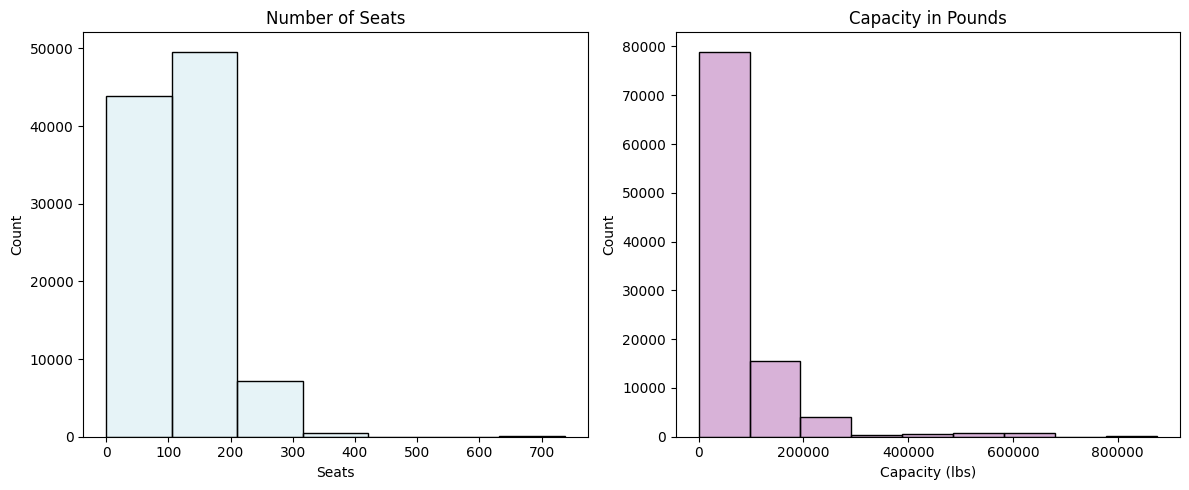

In [63]:
# plot a histogram
fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # make it wider so each plot has room

# NUMBER_OF_SEATS
sns.histplot(inventory['NUMBER_OF_SEATS'], binwidth=100, alpha=0.3, color='lightblue', ax=ax[0])
ax[0].set_title('Number of Seats')
ax[0].set_xlabel('Seats')
ax[0].set_ylabel('Count')

# CAPACITY_IN_POUNDS
sns.histplot(inventory['CAPACITY_IN_POUNDS'], binwidth=100000, alpha=0.3, color='purple', ax=ax[1])
ax[1].set_title('Capacity in Pounds')
ax[1].set_xlabel('Capacity (lbs)')
ax[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

In [64]:
# Apply (scipy.stats.boxcox) transformation to columns and save as new column: XXXXXXX_BOXCOX

# NUMBER OF SEATS has 0.0 values so must be transformed to use boxcox
inventory['NUMBER_OF_SEATS_BOXCOX'] = inventory['NUMBER_OF_SEATS'] + 0.000001
inventory['NUMBER_OF_SEATS_BOXCOX'], _ = scipy.stats.boxcox(inventory['NUMBER_OF_SEATS_BOXCOX'])


# CAPACITY IN POUNDS has 0.0 values so must be transformed to use boxcox
inventory['CAPACITY_IN_POUNDS_BOXCOX'] = inventory['CAPACITY_IN_POUNDS'] + 0.000001
inventory['CAPACITY_IN_POUNDS_BOXCOX'], _ = scipy.stats.boxcox(inventory['CAPACITY_IN_POUNDS_BOXCOX'])

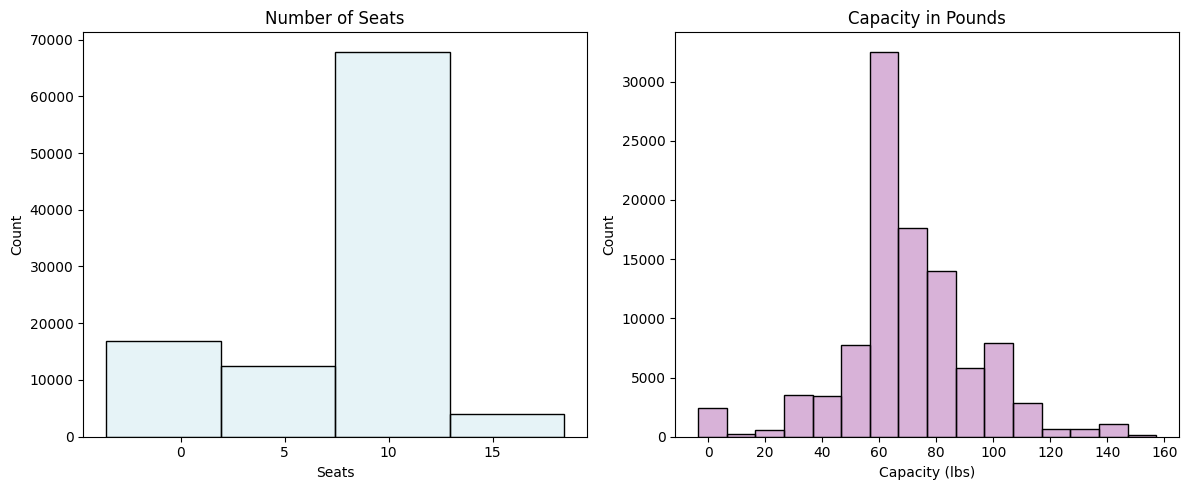

In [65]:
# Plot a histogram for each transformed variable.
fig, ax = plt.subplots(1, 2, figsize=(12, 5))  # make it wider so each plot has room

# NUMBER_OF_SEATS
sns.histplot(inventory['NUMBER_OF_SEATS_BOXCOX'], binwidth=5, alpha=0.3, color='lightblue', ax=ax[0])
ax[0].set_title('Number of Seats')
ax[0].set_xlabel('Seats')
ax[0].set_ylabel('Count')

# CAPACITY_IN_POUNDS
sns.histplot(inventory['CAPACITY_IN_POUNDS_BOXCOX'], binwidth=10, alpha=0.3, color='purple', ax=ax[1])
ax[1].set_title('Capacity in Pounds')
ax[1].set_xlabel('Capacity (lbs)')
ax[1].set_ylabel('Count')

plt.tight_layout()
plt.show()

**QUESTION 05**

In [66]:
# Create a new column SIZE by the quartiles of NUMBER_OF_SEATS
# below 25% percentile: SMALL
# 25% - 50% percentile: MEDIUM
# 50% - 75% percentile: LARGE
# above 75% percentile: XLARGE
inventory['SIZE'] = pd.qcut(inventory['NUMBER_OF_SEATS'], q=4, labels=['SMALL', 'MEDIUM', 'LARGE', 'XLARGE'])
# inventory['SIZE'].value_counts()

<ipython-input-71-10ec2de23d62>:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  status_counts = inventory.groupby(['SIZE', 'OPERATING_STATUS']).size().reset_index(name='count')
<ipython-input-71-10ec2de23d62>:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts = status_counts.groupby('SIZE')['count'].transform('sum')
<ipython-input-71-10ec2de23d62>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-71-10ec2de23d62>:16: FutureWarning: 

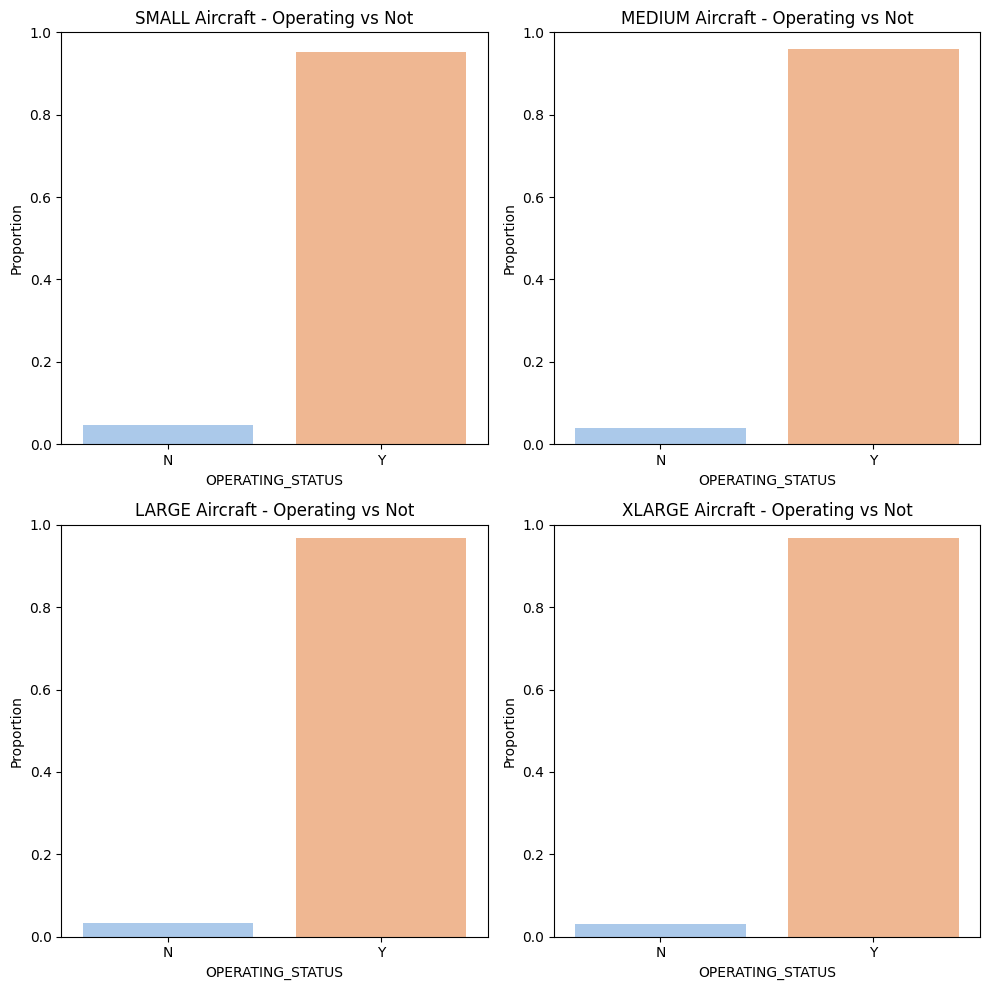

In [71]:
# For each size group, provide and plot the proportions of aircrafts that are operating versus not (OPERATING_STATUS).
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

locs = [ax[0,0], ax[0,1], ax[1,0], ax[1,1]]
sizes = ['SMALL', 'MEDIUM', 'LARGE', 'XLARGE']

# group by size and operating status
status_counts = inventory.groupby(['SIZE', 'OPERATING_STATUS']).size().reset_index(name='count')

# make proportion column
total_counts = status_counts.groupby('SIZE')['count'].transform('sum')
status_counts['proportion'] = status_counts['count'] / total_counts

# bar plots
for loc, size in zip(locs, sizes):
  sns.barplot(
      data=status_counts[status_counts['SIZE'] == size],
      x='OPERATING_STATUS', y='proportion', ax=loc, palette='pastel'
  )
  loc.set_title(f'{size} Aircraft - Operating vs Not')
  loc.set_ylim(0, 1)
  loc.set_ylabel('Proportion')

plt.tight_layout()
plt.show()

<ipython-input-70-95d4a303e71c>:8: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  status_counts = inventory.groupby(['SIZE', 'AIRCRAFT_STATUS']).size().reset_index(name='count')
<ipython-input-70-95d4a303e71c>:11: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  total_counts = status_counts.groupby('SIZE')['count'].transform('sum')
<ipython-input-70-95d4a303e71c>:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
<ipython-input-70-95d4a303e71c>:16: FutureWarning: 


<module 'matplotlib.pyplot' from '/usr/local/lib/python3.11/dist-packages/matplotlib/pyplot.py'>

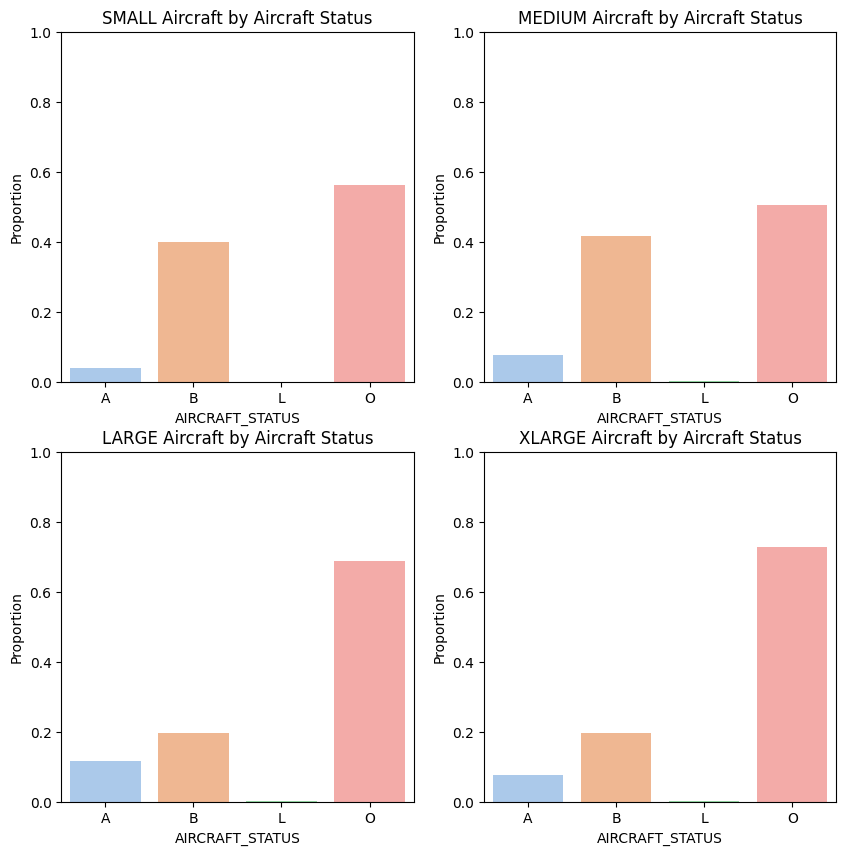

In [70]:
# For each size group, provide and plot the proportions of aircrafts belonging to each aircraft status group (AIRCRAFT_STATUS)
fig, ax = plt.subplots(2, 2, figsize=(10, 10))

locs = [ax[0,0], ax[0,1], ax[1,0], ax[1,1]]
sizes = ['SMALL', 'MEDIUM', 'LARGE', 'XLARGE']

# group by size and operating status
status_counts = inventory.groupby(['SIZE', 'AIRCRAFT_STATUS']).size().reset_index(name='count')

# make proportions
total_counts = status_counts.groupby('SIZE')['count'].transform('sum')
status_counts['proportion'] = status_counts['count'] / total_counts

# bar plots
for loc, size in zip(locs, sizes):
  sns.barplot(
      data=status_counts[status_counts['SIZE'] == size],
      x='AIRCRAFT_STATUS', y='proportion', ax=loc, palette='pastel'
  )
  loc.set_title(f'{size} Aircraft by Aircraft Status')
  loc.set_ylim(0, 1)
  loc.set_ylabel('Proportion')

plt